In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_descriptions = pd.read_excel("proshares_analysis_data.xlsx", sheet_name="descriptions").rename(columns={"Unnamed: 0":"Name"})
data_hf = pd.read_excel("proshares_analysis_data.xlsx", sheet_name="hedge_fund_series").rename(columns={"Unnamed: 0":"Date"})
data_merrill = pd.read_excel("proshares_analysis_data.xlsx", sheet_name="merrill_factors").rename(columns={"Unnamed: 0":"Date"})
data_other = pd.read_excel("proshares_analysis_data.xlsx", sheet_name="other_data").rename(columns={"Unnamed: 0":"Date"})

# 1. For the series in the “hedge fund series” tab, report the following summary statistics:

## (a)(b)(c) Mean, volatility, sharpe

In [4]:
#Notice the mean time diff is a month, so annualize by mean *12, vol by *sqrt(12), etc.
data_hf['Date'].diff().mean()

Timedelta('30 days 10:22:58.723404255')

In [5]:
hf_stats = pd.DataFrame(data_hf.drop(columns=['Date']).mean()*12).rename(columns={0:"mean_annualized"})
hf_stats['vol_annualized'] = data_hf.drop(columns=['Date']).std()*np.sqrt(12)
hf_stats['sharpe_annualized'] = hf_stats['mean_annualized'] / hf_stats['vol_annualized'] #same as mult monthly mean/vol by sqrt(12)

hf_stats

,mean_annualized,vol_annualized,sharpe_annualized
HFRIFWI Index,0.041447,0.060416,0.686023
MLEIFCTR Index,0.030670,0.057147,0.536686
MLEIFCTX Index,0.029239,0.056985,0.513102
HDG US Equity,0.019442,0.059589,0.326268
QAI US Equity,0.016958,0.049895,0.339873


1 ANSWER) Stats above

# 2. For the series in the “hedge fund series” tab, calculate the following statistics related to tail-risk.


## (a) Skewness

In [6]:
hf_stats['skewness'] = data_hf.drop(columns=['Date']).skew()
hf_stats['skewness']

HFRIFWI Index    -0.979063
MLEIFCTR Index   -0.244981
MLEIFCTX Index   -0.231032
HDG US Equity    -0.233880
QAI US Equity    -0.461338
Name: skewness, dtype: float64

## (b) Kurtosis

In [7]:
hf_stats['kurtosis'] = data_hf.drop(columns=['Date']).kurtosis()
hf_stats['kurtosis']

HFRIFWI Index     5.955123
MLEIFCTR Index    1.689648
MLEIFCTX Index    1.657903
HDG US Equity     1.799098
QAI US Equity     1.825993
Name: kurtosis, dtype: float64

## (c) the fifth quantile of historic returns, which is also known as the Value-at-Risk (VaR)


In [8]:
hf_stats['VaR'] = data_hf.drop(columns=['Date']).quantile(0.05) #Top 20%
hf_stats['VaR']

HFRIFWI Index    -0.025324
MLEIFCTR Index   -0.028764
MLEIFCTX Index   -0.029119
HDG US Equity    -0.031209
QAI US Equity    -0.020593
Name: VaR, dtype: float64

## (d) the mean of the returns at or below the fifth quantile, which is also known as the Conditional Value-at-Risk (CVaR)

In [9]:
datedropped = data_hf.drop(columns=['Date'])
hf_stats['CVaR'] = datedropped[datedropped <= datedropped.quantile(0.05)].mean()
hf_stats['CVaR']

HFRIFWI Index    -0.037478
MLEIFCTR Index   -0.035857
MLEIFCTX Index   -0.035816
HDG US Equity    -0.037577
QAI US Equity    -0.032695
Name: CVaR, dtype: float64


## (e) Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

In [10]:
def get_max_drawdown(df, asset):
    ret_series = np.array((df[asset] + 1).cumprod())
    #super lazy O(n^2) soln, leetcoders would cry
    max_dd_percent = 0
    max_dd_start = -1
    max_dd_end = -1
    for i_l, val_l in enumerate(ret_series[:-1]):
        for i_r, val_r in enumerate(ret_series[i_l+1:]):
            percent_delta = (val_l - val_r) / val_l
            if i_l < i_r and val_l > val_r and percent_delta > max_dd_percent:
                max_dd_percent = percent_delta
                max_dd_start = i_l
                max_dd_end = i_r

    return (-1*max_dd_percent, max_dd_start, max_dd_end)

In [11]:
#again, a bit (very) lazy

hf_stats["max_drawdown"] = 0
dd_list = []
dd_start_list = []
dd_end_list = []
date_list = list(data_hf["Date"])
for col in list(data_hf.columns[1:]):
    r = get_max_drawdown(data_hf, col)
    dd_list.append(r[0])
    dd_start_list.append(date_list[r[1]])
    dd_end_list.append(date_list[r[2]])

hf_stats["max_drawdown"] = dd_list
hf_stats['max_drawdown_start'] = dd_start_list
hf_stats['max_drawdown_end'] = dd_end_list
hf_stats

,mean_annualized,vol_annualized,sharpe_annualized,skewness,kurtosis,VaR,CVaR,max_drawdown,max_drawdown_start,max_drawdown_end
HFRIFWI Index,0.041447,0.060416,0.686023,-0.979063,5.955123,-0.025324,-0.037478,-0.030728,2011-08-31,2011-11-30
MLEIFCTR Index,0.030670,0.057147,0.536686,-0.244981,1.689648,-0.028764,-0.035857,-0.022339,2011-10-31,2012-02-29
MLEIFCTX Index,0.029239,0.056985,0.513102,-0.231032,1.657903,-0.029119,-0.035816,-0.023477,2011-10-31,2012-02-29
HDG US Equity,0.019442,0.059589,0.326268,-0.233880,1.799098,-0.031209,-0.037577,-0.033924,2011-10-31,2012-02-29
QAI US Equity,0.016958,0.049895,0.339873,-0.461338,1.825993,-0.020593,-0.032695,-0.013911,2015-02-28,2015-05-31


2 ANSWER) See all stats above ^

## 3. For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics:

In [35]:
#calculating regression with intercept
def univ_regr(y, X, adj = 12):
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing="drop")
    results = model.fit()

    intercept = results.params[0]
    beta = results.params[1]
    rsq = results.rsquared
    treynor = (y.mean() / beta) * adj
    information = (intercept / results.resid.std()) * np.sqrt(adj)

    summary = {"Alpha": intercept, "Beta": beta, "R-Squared": rsq, "Treynor Ratio": treynor, 
               "Information Ratio": information}
    summary_df = pd.DataFrame(summary, index=[y.name])
    return summary_df


In [36]:
spy = data_merrill["SPY US Equity"]
stats = pd.concat([univ_regr(data_hf[col], spy) for col in data_hf.columns[1:]], 
                  axis=0)
stats.index = data_hf.columns[1:]
stats


,Alpha,Beta,R-Squared,Treynor Ratio,Information Ratio
HFRIFWI Index,-0.000297,0.348217,0.710668,0.119027,-0.109520
MLEIFCTR Index,-0.001212,0.349859,0.801824,0.087664,-0.571877
MLEIFCTX Index,-0.001317,0.348514,0.800212,0.083896,-0.620547
HDG US Equity,-0.002252,0.359536,0.778808,0.054075,-0.964387
QAI US Equity,-0.001754,0.294096,0.743252,0.057662,-0.832728


# 4. Relative Performance. Discuss the previous statistics, and what they tell us about...

## (a) the differences between SPY and the hedge-fund series?

In [37]:
def risk_metrics(df, adj = 12):
    """
        df: dated DataFrame of returns, 1 column for each ticker
        
        returns a pd.DataFrame
    """
    dates = df['Date']
    df = df.drop('Date', axis = 1)
    adj = 12
    perf = pd.DataFrame()
    perf['mean_annualized'] = df.mean() * adj
    perf['vol_annualized'] = df.std() * np.sqrt(adj)
    perf['sharpe_annualized'] = df.mean() / df.std() * np.sqrt(adj)
    perf['skew'] = df.skew()
    perf['kurtosis'] = df.kurtosis()
    perf['VaR'] = df.quantile(0.05)
    perf['CVaR'] = df[(df - df.quantile(0.05)) < 0].mean()

    wealth = (1 + df).cumprod()
    previous_peaks = wealth.cummax()
    drawdowns = (wealth - previous_peaks)/previous_peaks
    perf["Max Drawdown"] = drawdowns.min()
    perf['Peak'] = [dates[i] for i in drawdowns.idxmax()]
    perf['Bottom'] =  [dates[i] for i in drawdowns.idxmin()]

    recovery_date = []
    for ticker in wealth.columns:
        prev_max = previous_peaks[ticker][: drawdowns[ticker].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth[ticker][drawdowns[ticker].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[ticker] >= prev_max].index.min()
        )
    perf["Recovery"] = ["-" if pd.isnull(i) else dates[i] for i in recovery_date]

    perf["Duration (days)"] = [
        (i - j).days if i != "-" else "-"
        for i, j in zip(perf["Recovery"], perf["Bottom"])
    ]
    return perf


In [38]:
pd.concat([risk_metrics(data_merrill[['Date', 'SPY US Equity']]), risk_metrics(data_hf)])

,mean_annualized,vol_annualized,sharpe_annualized,skew,kurtosis,VaR,CVaR,Max Drawdown,Peak,Bottom,Recovery,Duration (days)
SPY US Equity,0.129248,0.146265,0.883658,-0.405414,0.796696,-0.068837,-0.086619,-0.239280,2011-08-31,2022-09-30,-,-
HFRIFWI Index,0.041447,0.060416,0.686023,-0.979063,5.955123,-0.025324,-0.037478,-0.115473,2011-08-31,2020-03-31,2020-08-31 00:00:00,153
MLEIFCTR Index,0.030670,0.057147,0.536686,-0.244981,1.689648,-0.028764,-0.035857,-0.124302,2011-08-31,2022-09-30,-,-
MLEIFCTX Index,0.029239,0.056985,0.513102,-0.231032,1.657903,-0.029119,-0.035816,-0.124388,2011-08-31,2022-09-30,-,-
HDG US Equity,0.019442,0.059589,0.326268,-0.233880,1.799098,-0.031209,-0.037577,-0.140721,2011-08-31,2022-09-30,-,-
QAI US Equity,0.016958,0.049895,0.339873,-0.461338,1.825993,-0.020593,-0.032695,-0.137712,2011-08-31,2022-09-30,-,-


Answer: 
- SPY has greater annualized mean and Sharpe than all hedge fund indices.
- However its VaR and CVaR are much worse, as well as max drawdown. This means that the "worst-case scenarios" of SPY are worse than the hedge funds, so indeed the hedge fund indices do provide some sort of "hedging"



## (b) which performs better between HDG and QAI

In [39]:
risk_metrics(data_hf)

,mean_annualized,vol_annualized,sharpe_annualized,skew,kurtosis,VaR,CVaR,Max Drawdown,Peak,Bottom,Recovery,Duration (days)
HFRIFWI Index,0.041447,0.060416,0.686023,-0.979063,5.955123,-0.025324,-0.037478,-0.115473,2011-08-31,2020-03-31,2020-08-31 00:00:00,153
MLEIFCTR Index,0.030670,0.057147,0.536686,-0.244981,1.689648,-0.028764,-0.035857,-0.124302,2011-08-31,2022-09-30,-,-
MLEIFCTX Index,0.029239,0.056985,0.513102,-0.231032,1.657903,-0.029119,-0.035816,-0.124388,2011-08-31,2022-09-30,-,-
HDG US Equity,0.019442,0.059589,0.326268,-0.233880,1.799098,-0.031209,-0.037577,-0.140721,2011-08-31,2022-09-30,-,-
QAI US Equity,0.016958,0.049895,0.339873,-0.461338,1.825993,-0.020593,-0.032695,-0.137712,2011-08-31,2022-09-30,-,-


In [40]:
pd.concat(
    [univ_regr(data_hf['HDG US Equity'], data_merrill['SPY US Equity']),
    univ_regr(data_hf['QAI US Equity'], data_merrill['SPY US Equity'])]
)


,Alpha,Beta,R-Squared,Treynor Ratio,Information Ratio
HDG US Equity,-0.002252,0.359536,0.778808,0.054075,-0.964387
QAI US Equity,-0.001754,0.294096,0.743252,0.057662,-0.832728


Answer:
- Based on risks, they are very similar, perhaps with slight difference in skew.
- However, because they are hedge fund indices, we look to their correlation with SPY to see if they provide any edge over SPY. QAI is better because its $r^2$ is lower, and slightly greater $\alpha$ as well. 

## (c) whether HDG and the ML series capture the most notable properties of HFRI.

In [42]:
pd.concat(
    [univ_regr(data_hf['HFRIFWI Index'], data_hf['MLEIFCTR Index']),
    univ_regr(data_hf['HFRIFWI Index'], data_hf['MLEIFCTX Index']),
    univ_regr(data_hf['HFRIFWI Index'], data_hf['HDG US Equity'])],
)

,Alpha,Beta,R-Squared,Treynor Ratio,Information Ratio
HFRIFWI Index,0.001034,0.946981,0.802341,0.043768,0.461765
HFRIFWI Index,0.001142,0.948980,0.801157,0.043675,0.508522
HFRIFWI Index,0.002001,0.896975,0.782678,0.046208,0.852416


By eye-inspection, the risk metrics of these hedge fund indices are quite similar. We regressed HFRIFWI against each index to see more precisely how they're correlated with each other: The high $r^2$ scores throughout indicate that they do capture the properties of HFRI.

# 5. Report the correlation matrix for these assets.

## (a) Show the correlations as a heat map.

In [47]:
data_all = pd.concat([data_hf.drop('Date', axis = 1), data_merrill.drop('Date', axis = 1)], axis = 1)
data_all

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
0,-0.032149,-0.025588,-0.025689,-0.027035,-0.006491,-0.054976,0.000009,-0.092549,-0.087549,-0.005889,-0.088913
1,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142,-0.069449,0.000017,-0.179064,-0.108083,0.142180,-0.111541
2,0.026858,0.043593,0.043320,0.050532,0.025241,0.109147,-0.000013,0.162986,0.096275,-0.069502,0.151012
3,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965,-0.004064,0.000000,-0.019723,-0.021764,0.054627,-0.003783
4,-0.004479,0.001938,0.001796,0.012875,0.001854,0.010440,0.000009,-0.043017,-0.022139,0.075581,0.005114
...,...,...,...,...,...,...,...,...,...,...,...
137,0.026600,0.034428,0.034050,0.035244,0.029164,0.062887,0.003868,0.091292,0.090037,-0.025467,0.098188
138,-0.006382,-0.001587,-0.001932,-0.002426,-0.008538,-0.025143,0.003974,-0.075677,-0.030748,0.059930,-0.017234
139,-0.008032,-0.004996,-0.004926,-0.006959,0.005856,0.037125,0.003911,0.032173,0.031291,-0.045368,-0.048459
140,0.002378,0.000852,0.000333,-0.000440,0.005135,0.015975,0.004192,-0.008363,0.029362,-0.027593,-0.017937


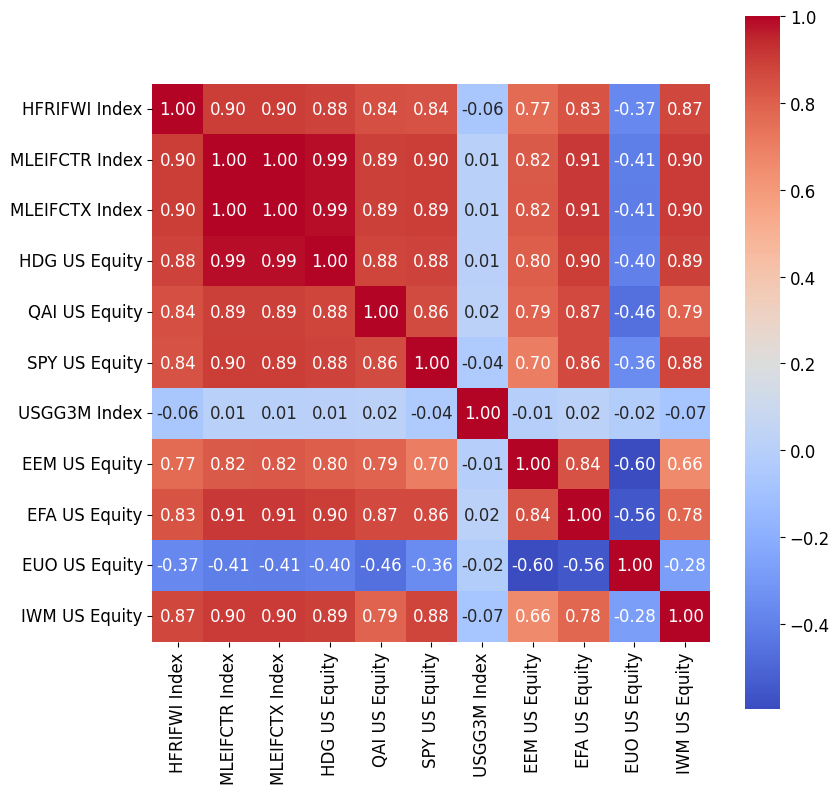

In [59]:
sns.heatmap(data_all.corr(), annot=True, cmap='coolwarm', fmt=".2f",square=True)
plt.show()

In [72]:
# Find the argmax of the highest correlation
corrdf = data_all.corr()
stackcorr = np.abs(corrdf[corrdf != 1].stack())
max_corr = stackcorr.max()
argmax_corr = stackcorr.idxmax()

# Find the argmin of the lowest correlation
min_corr = stackcorr.min()
argmin_corr = stackcorr.idxmin()

print(f'Max corr: {argmax_corr} at {max_corr}, min corr: {argmin_corr} at {min_corr}')

Max corr: ('MLEIFCTR Index', 'MLEIFCTX Index') at 0.9999250790945599, min corr: ('MLEIFCTX Index', 'USGG3M Index') at 0.006336303354738432
